In [1]:
import warnings
warnings.filterwarnings("ignore")
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import math
import matplotlib.pyplot as plt
import contractions
import re
import random
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
additional  = ['rt','rts','retweet'] # lista adicional de stopwords
swords = set().union(stopwords.words('english'),additional) # adicionando palavras para o stopwords

pd.options.display.float_format = '{:,.2f}'.format

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rbsa2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# controla tamanho geral das figuras no matplotlib/seaborn
TAMANHO_GERAL = [15, 10]
plt.rcParams['figure.figsize'] = TAMANHO_GERAL
sns.set(rc={'figure.figsize' : TAMANHO_GERAL})

In [3]:
# https://www.kaggle.com/kaushiksuresh147/bitcoin-tweets
p = 0.005

dataFrame = pd.read_csv('D:\SiDi\Project\dataset\Bitcoin_tweets.csv', skiprows=lambda i: i>0 and random.random() > p, lineterminator='\n' )
# dataFrame['date'] = pd.to_datetime(dataFrame['date']).dt.date
# twFrame = pd.read_csv('Data/Bitcoin_tweets_6_2_2021.csv')dataFrame 
#dataFrame = pd.read_csv('tweets.csv', delimiter=';', skiprows=0, lineterminator='\n' )
dataFrame.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,SeeG,Above You !,"Veni-Vidi-Tweeti / in #btc, #eth, #vet, #vtho,...",2019-10-09 21:25:48,8.00,0.00,49.00,False,2021-02-10 22:52:32,#btc #bitcoin #Ethereum #ETH #dogecoin ...,"['btc', 'bitcoin', 'Ethereum', 'ETH', 'dogecoi...",Twitter for iPhone,False
1,Blockchain Guardian,NaN,BTC🚀🌜\nNot a financial advice...\nTA & NEWS\n\...,2019-11-14 10:31:33,77.00,804.00,908.00,False,2021-02-10 19:44:27,#twitter #BTC #bitcoin #investing #smartmoney ...,"['twitter', 'BTC', 'bitcoin', 'investing', 'sm...",Instagram,False
2,Mikcoin,NaN,"Technical Analyst | Trader\n\nNo certainty, on...",2020-11-26 23:45:46,104.00,41.00,238.00,False,2021-02-10 18:26:40,#BTC #Bitcoin #Ethereum #ETH #Crypto #cryptotr...,"['BTC', 'Bitcoin', 'Ethereum', 'ETH', 'Crypto'...",Twitter for Android,False
3,PiRoyot,NaN,Test Twitter Bot for Pi,2020-06-07 10:46:59,1.00,0.00,0.00,False,2021-02-10 16:30:02,Market Id : BTC-AUD\nLast Price :58199.44\n24 ...,"['btc', 'bitcoin']",HashTagTrendRoy,False
4,Trading Surfers,NaN,Certified #Elliottwave Analysts - EW counts fo...,2013-03-20 15:09:40,"6,052.00",156.00,298.00,False,2021-02-10 15:30:21,Bitcoin Update 📉\n\nCharts are released earlie...,['joinus'],Buffer,False


In [4]:
indexes2Drop = dataFrame[dataFrame['date'].str.contains("bitcoin|Bitcoin|ETH|btc|BTC")].index
dataFrame.drop(indexes2Drop,inplace=True)

ValueError: Cannot mask with non-boolean array containing NA / NaN values

In [5]:
dataFrame['date'] = pd.to_datetime(dataFrame['date']).dt.date
# pd.to_datetime(dataFrame['date'])dt.date

In [6]:
twFrame = dataFrame[['date','text']]
twFrame

,date,text
0,2021-02-10,#btc #bitcoin #Ethereum #ETH #dogecoin ...
1,2021-02-10,#twitter #BTC #bitcoin #investing #smartmoney ...
2,2021-02-10,#BTC #Bitcoin #Ethereum #ETH #Crypto #cryptotr...
3,2021-02-10,Market Id : BTC-AUD\nLast Price :58199.44\n24 ...
4,2021-02-10,Bitcoin Update 📉\n\nCharts are released earlie...
...,...,...
9464,2021-11-06,How To Invest in Real Estate and Succeed!\n#SH...
9465,2021-11-05,#IMX - short alert 🤦🏻💩\n\nTicker : $IMX\nM...
9466,2021-11-05,@WatcherGuru So bullish#INDC It has unlimited ...
9467,2021-11-05,@RUShibbinMe 🪐🪐Spacelab Token - 5% BTC AWARDED...


In [8]:
twText = twFrame[['text']]
twText

,text
0,#btc #bitcoin #Ethereum #ETH #dogecoin ...
1,#twitter #BTC #bitcoin #investing #smartmoney ...
2,#BTC #Bitcoin #Ethereum #ETH #Crypto #cryptotr...
3,Market Id : BTC-AUD\nLast Price :58199.44\n24 ...
4,Bitcoin Update 📉\n\nCharts are released earlie...
...,...
9464,How To Invest in Real Estate and Succeed!\n#SH...
9465,#IMX - short alert 🤦🏻💩\n\nTicker : $IMX\nM...
9466,@WatcherGuru So bullish#INDC It has unlimited ...
9467,@RUShibbinMe 🪐🪐Spacelab Token - 5% BTC AWARDED...


In [9]:
twText['text'] = twText['text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0]) # remove urls
twText['text'] = twText['text'].str.replace('\d+', '') # remove valores numericos
twText.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))
text = twText['text'][0]
text

'#btc\xa0\xa0\xa0 #bitcoin\xa0\xa0\xa0 #Ethereum  #ETH #dogecoin #Cardano #ada #Solana #sol #VeChain #VET #VeThor #VTHO Cardano and Solana @ ATH !! 🥳🥳'

In [10]:
def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words '''
    
    # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub("@[A-Za-z0-9_]+","", text) #remove menções
    text = re.sub(r'#[a-zA-z0-9]+','',text) # remove hashtag
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)        
    text = re.sub('[()!?]', ' ', text)
    text = re.sub('\[.*?\]',' ', text)
    text = re.sub("[^a-z0-9]"," ", text)
    text = contractions.fix(text)
    # text = ''.join(c for c in tweet if c not in emoji.UNICODE_EMOJI)
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    # words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

In [11]:
twFrame['cleantext']=twText['text'].map(lambda x: tweet_to_words(x))
twFrame

,date,text,cleantext
0,2021-02-10,#btc #bitcoin #Ethereum #ETH #dogecoin ...,"[cardano, solana, ath]"
1,2021-02-10,#twitter #BTC #bitcoin #investing #smartmoney ...,[twitter]
2,2021-02-10,#BTC #Bitcoin #Ethereum #ETH #Crypto #cryptotr...,"[band, funding, back, normal, crash]"
3,2021-02-10,Market Id : BTC-AUD\nLast Price :58199.44\n24 ...,"[market, id, btc, aud, last, price, hour, high..."
4,2021-02-10,Bitcoin Update 📉\n\nCharts are released earlie...,"[bitcoin, update, charts, released, earlier, d..."
...,...,...,...
9464,2021-11-06,How To Invest in Real Estate and Succeed!\n#SH...,"[invest, real, estate, succeed]"
9465,2021-11-05,#IMX - short alert 🤦🏻💩\n\nTicker : $IMX\nM...,"[short, alert, ticker, imx, market, imx, usd, ..."
9466,2021-11-05,@WatcherGuru So bullish#INDC It has unlimited ...,"[bullish, unlimited, potential, scooping, dips..."
9467,2021-11-05,@RUShibbinMe 🪐🪐Spacelab Token - 5% BTC AWARDED...,"[spacelab, token, btc, awarded, automatic, reb..."


In [12]:
pd.DatetimeIndex(twFrame["date"]).date

array([datetime.date(2021, 2, 10), datetime.date(2021, 2, 10),
       datetime.date(2021, 2, 10), ..., datetime.date(2021, 11, 5),
       datetime.date(2021, 11, 5), datetime.date(2021, 11, 5)],
      dtype=object)

In [13]:
# import contractions
# text = '''She'd like to know how I'd done that! 
#           She's going to the park and I don't think I'll be home for dinner.
#           Theyre going to the zoo and she'll be home for dinner.'''
  
# text = contractions.fix(text)
# print(text)

In [14]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# import SentimentIntensityAnalyzer class
# from vaderSentiment.vaderSentiment module.
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
 
# function to print sentiments
# of the sentence.
def sentiment_scores(sentence):
 
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
    
    return sentiment_dict['compound']
     
 
    # decide sentiment as positive, negative and neutral
#     if sentiment_dict['compound'] >= 0.05 :
#         return "Positive"
 
#     elif sentiment_dict['compound'] <= - 0.05 :
#          return  "Negative"
 
#     else :
#          return "Neutral"

In [15]:
%%time
sentimental = [sentiment_scores(i) for i in twFrame['cleantext']]

twFrame["Sentimento"] = sentimental
twFrame["Sentimento"]

Wall time: 3min 15s


0      0.00
1      0.00
2      0.00
3      0.00
4      0.00
       ... 
9464   0.00
9465   0.00
9466   0.00
9467   0.00
9468   0.00
Name: Sentimento, Length: 9469, dtype: float64

In [16]:
twFrame["Sentimento"].describe()

count   9,469.00
mean        0.00
std         0.03
min        -0.53
25%         0.00
50%         0.00
75%         0.00
max         0.64
Name: Sentimento, dtype: float64

<AxesSubplot:xlabel='date'>

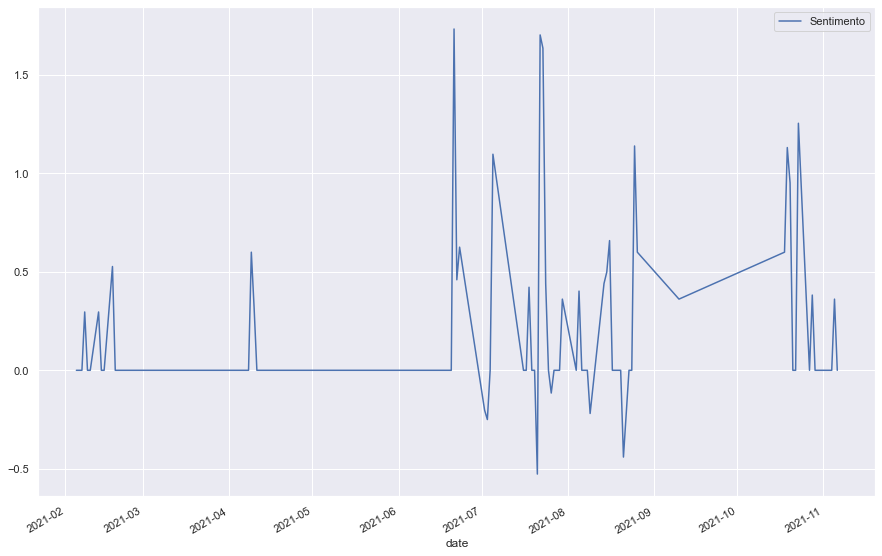

In [17]:
pd.DatetimeIndex(twFrame['date']).normalize()
# twFrame.groupby(pd.DatetimeIndex(twFrame['date']).normalize())['Sentimento'].sum().sort_values()
twFrame.groupby(pd.DatetimeIndex(twFrame['date']).normalize())['Sentimento'].sum().plot(legend=True)


In [18]:
# twFrame[(twFrame["Sentimento"].sort_values() > 0.2) | (twFrame["Sentimento"].sort_values() < -0.2) ]
# twFrame.groupby(pd.DatetimeIndex(twFrame['date']).normalize())['Sentimento'].sum()
g = twFrame.groupby(pd.DatetimeIndex(twFrame['date']).normalize()).sum()
g.reset_index(inplace = True)
g

,date,Sentimento
0,2021-02-05,0.00
1,2021-02-06,0.00
2,2021-02-07,0.00
3,2021-02-08,0.30
4,2021-02-09,0.00
...,...,...
84,2021-10-28,0.38
85,2021-10-29,0.00
86,2021-11-04,0.00
87,2021-11-05,0.36


In [19]:

minmaxpoints = g[ (g['Sentimento'] >= 0.2) | (g['Sentimento'] <= -0.2) ]
minmaxpoints['date'] = pd.to_datetime(minmaxpoints['date']).dt.date
# minmaxpoints['date'] = pd.to_datetime(minmaxpoints['date'], format='%y-%m-%d')
minmaxpoints

,date,Sentimento
3,2021-02-08,0.30
6,2021-02-13,0.30
9,2021-02-18,0.53
18,2021-04-09,0.60
19,2021-04-10,0.32
36,2021-06-21,1.73
37,2021-06-22,0.46
38,2021-06-23,0.62
39,2021-07-02,-0.20
40,2021-07-03,-0.25


In [20]:
minmaxpoints['date'] = minmaxpoints['date'].astype(str)
aa = list(minmaxpoints['date'])
aa

['2021-02-08',
 '2021-02-13',
 '2021-02-18',
 '2021-04-09',
 '2021-04-10',
 '2021-06-21',
 '2021-06-22',
 '2021-06-23',
 '2021-07-02',
 '2021-07-03',
 '2021-07-05',
 '2021-07-18',
 '2021-07-21',
 '2021-07-22',
 '2021-07-23',
 '2021-07-24',
 '2021-07-30',
 '2021-08-05',
 '2021-08-09',
 '2021-08-14',
 '2021-08-15',
 '2021-08-16',
 '2021-08-21',
 '2021-08-25',
 '2021-08-26',
 '2021-09-10',
 '2021-10-18',
 '2021-10-19',
 '2021-10-20',
 '2021-10-23',
 '2021-10-28',
 '2021-11-05']

In [21]:
twFrame.to_csv('D:\\SiDi\\Project\\dataset\\tweet_sentiment_analysis.csv')

In [22]:
btcPrice = pd.read_csv('D:\\SiDi\\Project\\dataset\\BTC-USD.csv')
# btcPrice[btcPrice['Date'] == '2021-02-08']
btcPrice

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.86,468.17,452.42,457.33,457.33,"21,056,800.00"
1,2014-09-18,456.86,456.86,413.10,424.44,424.44,"34,483,200.00"
2,2014-09-19,424.10,427.83,384.53,394.80,394.80,"37,919,700.00"
3,2014-09-20,394.67,423.30,389.88,408.90,408.90,"36,863,600.00"
4,2014-09-21,408.08,412.43,393.18,398.82,398.82,"26,580,100.00"
...,...,...,...,...,...,...,...
2607,2021-11-06,"61,068.88","61,590.68","60,163.78","61,527.48","61,527.48","29,094,934,221.00"
2608,2021-11-07,"61,554.92","63,326.99","61,432.49","63,326.99","63,326.99","24,726,754,302.00"
2609,2021-11-08,"63,344.07","67,673.74","63,344.07","67,566.83","67,566.83","41,125,608,330.00"
2610,2021-11-09,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
btcPrice.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [24]:
# btcPrice.loc[btcPrice['Date'] == teste]
# btcPrice[btcPrice['Date'] == teste]
    

In [25]:
# btcPrice.loc[btcPrice['Date'].isin([aa])]
zz = btcPrice.query('Date in @aa')
zz
btcPrice.loc[zz.index,'teste'] = True
btcPrice['teste'] = btcPrice['teste'].replace(np.nan,False)
btcPrice['Date']

0       2014-09-17
1       2014-09-18
2       2014-09-19
3       2014-09-20
4       2014-09-21
           ...    
2607    2021-11-06
2608    2021-11-07
2609    2021-11-08
2610    2021-11-09
2611    2021-11-10
Name: Date, Length: 2612, dtype: object

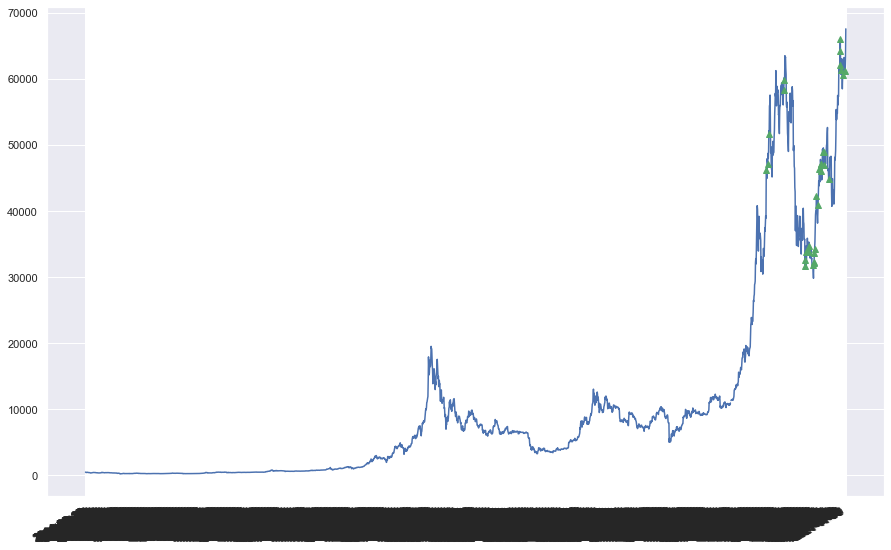

In [26]:
# btcPrice.plot(x='Date', y=['Close','teste'])


# fig, ax1 = plt.subplots()
# ax1.plot(btcPrice['Date'],btcPrice['Close'])
# ax1.plot(btcPrice['Date'],btcPrice['teste'],marker='o')

ts = btcPrice['Close'] 
ts2 = ts[btcPrice['teste']]

fig, ax1 = plt.subplots()
ax1.plot(btcPrice['Date'], ts)       
ax1.plot(ts2.index, ts2,'g^')
fig.autofmt_xdate()